# Code to map velocities using autoRIFT with adjustable parameters

_Last modified on 2022-05-17 by jukesliu@u.boisestate.edu._

Majority of the code is borrowed from testGeogrid_ISCE.py and testautoRIFT_ISCE.py from the autoRIFT GitHub repository (https://github.com/nasa-jpl/autoRIFT/). Requires ISCE and autoRIFT to be installed.

Change the kernel to __newautoriftenv__.

In [2]:
import rasterio as rio
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from scipy.interpolate import interp2d

## 1) Resample DEM and other autoRIFT/geogrid input rasters to the desired chip size

Recommended chip size is >= 16*pixel_resolution

#### Customizable parameters for geogrid:

    dhdx, dhdy:              x/y local surface slope maps (unitless)
    vx,vy:                   x/y reference velocity maps (in units of m/yr)
    srx, sry:                x/y velocity search range limit maps (in units of m/yr)
    csminx, csminy:          x/y chip size minimum maps (in units of m; constant ratio between x and y)
    csmaxx, csmaxy:          x/y chip size maximum maps (in units of m; constant ratio between x and y)
    ssm:                     stable surface mask (boolean)

In [3]:
######### ENTER CHIP SIZE, DEM INFO, AND REFERENCE VELOCITY INFO ########### 
CHIPSIZE_M = 160 # enter in desired grid size in meters (default is 32 pixels)

# enter in the path to your best DEM over the region
dempath = '/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/DEMs_previous/'
demname = 'IfSAR_5m_DSM_clipped.tif'

# path to the reference files for geogrid (vx, vy, ssm)
refvpath = '/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/forAutoRIFT/' 
vx_fname = 'vx_cropped.tif' # name of reference vx file
vy_fname = 'vy_cropped.tif' # name of reference vy file
############################################################################

In [4]:
# Read and grab info from your DEM
refdem = rio.open(dempath+demname) # open DEM using rasterio
elev = refdem.read(1) # read in the first and only band (elevations)

# grab the x and y grid values from the DEM:
dem_x = np.linspace(refdem.bounds.left, refdem.bounds.right, num=np.shape(elev)[1])
dem_y = np.linspace(refdem.bounds.top, refdem.bounds.bottom, num=np.shape(elev)[0])

# grab the resampled x and y grid values from the DEM
new_x = np.arange(refdem.bounds.left, refdem.bounds.right, CHIPSIZE_M)
new_y = np.arange(refdem.bounds.top, refdem.bounds.bottom, -CHIPSIZE_M)

In [5]:
dem_outfile = 'IfSAR_'+str(CHIPSIZE_M)+'m_DSM_clipped.tif' # generate new filename

if not os.path.exists(dempath+dem_outfile): # if the resampled DEM does not exist already
    # Create thew new x and y grid values using DEM bounds and the chipsize
    dem_resamp = np.zeros((len(new_y), len(new_x))) # create an empty resampled DEM grid
    print(dem_resamp.shape)
    
    # Resample to your new DEM bounds
    f = interp2d(dem_x, dem_y, elev) # create DEM interpolation object
    dem_resamp = f(new_x,new_y) # resample the NIR data to the DSM coordinates
    dem_resamp = np.flipud(dem_resamp) # flip up down
    print("Resampled to new dimensions:",dem_resamp.shape)
    
    # Display the two DEMs as a visual check
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
    im1 = ax1.imshow(elev, cmap='Greys_r', vmin=0)
    ax1.set_title('Original DEM: '+str(refdem.transform[0])+' m') # original spatial resolution
    fig.colorbar(im1, ax=ax1,label='Elevation [m]')

    im2 = ax2.imshow(dem_resamp, cmap='Greys_r', vmin=0)
    ax2.set_title('Resampled DEM: '+str(CHIPSIZE_M)+' m') # new spatial resolution
    fig.colorbar(im2, ax=ax2,label='Elevation [m]')
    plt.show()
    
    # Save the resampled DEM to georeferenced tif file
    print("Save resampled DEM to", dempath+dem_outfile)
    with rio.open(dempath+dem_outfile,'w',
                      driver='GTiff',
                      height=dem_resamp.shape[0], # new shape
                      width=dem_resamp.shape[1], # new shape
                      dtype=dem_resamp.dtype, # data type
                      count=1,
                      crs=refdem.crs, # the EPSG from the original DEM
                      transform=rio.Affine(CHIPSIZE_M, 0.0, refdem.bounds.left, # modified transform
                                           0.0, -CHIPSIZE_M, refdem.bounds.top)) as dst:
            dst.write(dem_resamp, 1)
else:
    # load the empty grid
    dem_resamp = np.zeros((len(new_y), len(new_x))) # create an empty resampled DEM grid
    print(dem_outfile, ' already exists.')

IfSAR_160m_DSM_clipped.tif  already exists.


### dhdx, dhdy

In [6]:
dhdx_outfile = 'IfSAR_'+str(CHIPSIZE_M)+'m_DSM_clipped_dhdx.tif' # generate new filename
dhdy_outfile = 'IfSAR_'+str(CHIPSIZE_M)+'m_DSM_clipped_dhdy.tif' # generate new filename

if not os.path.exists(dempath+dhdx_outfile) or not os.path.exists(dempath+dhdy_outfile): # if either is missing
    # Produce dhdx and dhdy maps from resampled DEM
    dhdx = np.gradient(dem_resamp, axis=1)/CHIPSIZE_M
    dhdy = np.gradient(dem_resamp, axis=0)/CHIPSIZE_M

    # Filter out borders with high gradient values
    grad_thresh = 5
    dhdx[abs(dhdx) > grad_thresh] = 0; dhdy[abs(dhdy) > grad_thresh] = 0

    # absolute value of the max gradient values expected:
    dhmax = 1

    # Display the two DEMs as a visual check
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
    im1 = ax1.imshow(dhdx, cmap='Greys_r', vmin=-dhmax, vmax=dhmax)
    ax1.set_title('dhdx') # surface slope x
    fig.colorbar(im1, ax=ax1)

    im2 = ax2.imshow(dhdy, cmap='Greys_r', vmin=-dhmax, vmax=dhmax)
    ax2.set_title('dhdy') # surface slope y
    fig.colorbar(im2, ax=ax2)
    plt.show()
    
    # Save the gradient maps to tif files
    print("Save surface slope maps to", dempath)

    # dhdx
    with rio.open(dempath+dhdx_outfile,'w',
                      driver='GTiff',
                      height=dhdx.shape[0], # new shape
                      width=dhdx.shape[1], # new shape
                      dtype=dhdx.dtype, # data type
                      count=1,
                      crs=refdem.crs, # the EPSG from the original DEM
                      transform=rio.Affine(CHIPSIZE_M, 0.0, refdem.bounds.left, # modified transform
                                           0.0, -CHIPSIZE_M, refdem.bounds.top)) as dst:
            dst.write(dhdx, 1)

    # dhdy
    with rio.open(dempath+dhdy_outfile,'w',
                      driver='GTiff',
                      height=dhdy.shape[0], # new shape
                      width=dhdy.shape[1], # new shape
                      dtype=dhdy.dtype, # data type
                      count=1,
                      crs=refdem.crs, # the EPSG from the original DEM
                      transform=rio.Affine(CHIPSIZE_M, 0.0, refdem.bounds.left, # modified transform
                                           0.0, -CHIPSIZE_M, refdem.bounds.top)) as dst:
            dst.write(dhdy, 1)
else:
    print(dhdy_outfile, 'and', dhdx_outfile, 'already exist.')

IfSAR_160m_DSM_clipped_dhdy.tif and IfSAR_160m_DSM_clipped_dhdx.tif already exist.


### vx, vy, srx, sry

In [7]:
############### SEARCH RANGE MULTIPLICATION FACTOR ###############
# search range limits are calculated as a scalar multiplied by the
# reference velocity distribution
sr_scaling = 16
##################################################################

# generate outfile names
vx_outfile = 'vx_'+str(CHIPSIZE_M)+'m.tif' # generate new filename
vy_outfile = 'vy_'+str(CHIPSIZE_M)+'m.tif' # generate new filename
srx_outfile = 'srx_'+str(CHIPSIZE_M)+'m.tif' # generate new filename
sry_outfile = 'sry_'+str(CHIPSIZE_M)+'m.tif' # generate new filename

if not os.path.exists(refvpath+vx_outfile) or not os.path.exists(refvpath+vy_outfile): # if either vx, vy missing
    # open the files with rasterio
    vx_reader = rio.open(refvpath+vx_fname); vx0 = vx_reader.read(1)
    vy_reader = rio.open(refvpath+vy_fname); vy0 = vy_reader.read(1)
    vx_x = np.linspace(vx_reader.bounds.left, vx_reader.bounds.right, num=np.shape(vx0)[1])
    vx_y = np.linspace(vx_reader.bounds.top, vx_reader.bounds.bottom, num=np.shape(vx0)[0])
    vy_x = np.linspace(vy_reader.bounds.left, vy_reader.bounds.right, num=np.shape(vy0)[1])
    vy_y = np.linspace(vy_reader.bounds.top, vy_reader.bounds.bottom, num=np.shape(vy0)[0])

    # Resample to the DEM grid
    fx = interp2d(vx_x, vx_y, vx0)
    fy = interp2d(vy_x, vy_y, vy0)
    vx_resamp = np.flipud(fx(new_x,new_y)) 
    vy_resamp = np.flipud(fy(new_x,new_y)) # flip up down

    # Display the two velocity files as a visual check
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
    im1 = ax1.imshow(vx_resamp, cmap='Greys_r'); ax1.set_title('vx'); fig.colorbar(im1, ax=ax1)
    im2 = ax2.imshow(vy_resamp, cmap='Greys_r'); ax2.set_title('vy'); fig.colorbar(im2, ax=ax2)
    plt.show()

    # CALCULATE SEARCH RANGE LIMITS MULTIPLY VX AND VY BY SOME NUMBER
    srx_resamp = vx_resamp*sr_scaling; sry_resamp = vy_resamp*sr_scaling

    # Display the two search range files as a visual check
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
    im1 = ax1.imshow(srx_resamp, cmap='Greys_r'); ax1.set_title('srx'); fig.colorbar(im1, ax=ax1)
    im2 = ax2.imshow(sry_resamp, cmap='Greys_r'); ax2.set_title('sry'); fig.colorbar(im2, ax=ax2)
    plt.show()
    
    # save the reference velocity and search range maps
    # vx
    with rio.open(refvpath+vx_outfile,'w',
                      driver='GTiff',
                      height=vx_resamp.shape[0], # new shape
                      width=vx_resamp.shape[1], # new shape
                      dtype=vx_resamp.dtype, # data type
                      count=1,
                      crs=refdem.crs, # the EPSG from the original DEM
                      transform=rio.Affine(CHIPSIZE_M, 0.0, refdem.bounds.left, # modified transform
                                           0.0, -CHIPSIZE_M, refdem.bounds.top)) as dst:
            dst.write(vx_resamp, 1)       
    # vy
    with rio.open(refvpath+vy_outfile,'w',
                      driver='GTiff',
                      height=vy_resamp.shape[0], # new shape
                      width=vy_resamp.shape[1], # new shape
                      dtype=vy_resamp.dtype, # data type
                      count=1,
                      crs=refdem.crs, # the EPSG from the original DEM
                      transform=rio.Affine(CHIPSIZE_M, 0.0, refdem.bounds.left, # modified transform
                                           0.0, -CHIPSIZE_M, refdem.bounds.top)) as dst:
            dst.write(vy_resamp, 1)
    # srx
    with rio.open(refvpath+srx_outfile,'w',
                      driver='GTiff',
                      height=srx_resamp.shape[0], # new shape
                      width=srx_resamp.shape[1], # new shape
                      dtype=srx_resamp.dtype, # data type
                      count=1,
                      crs=refdem.crs, # the EPSG from the original DEM
                      transform=rio.Affine(CHIPSIZE_M, 0.0, refdem.bounds.left, # modified transform
                                           0.0, -CHIPSIZE_M, refdem.bounds.top)) as dst:
            dst.write(srx_resamp, 1)
    # sry
    with rio.open(refvpath+sry_outfile,'w',
                      driver='GTiff',
                      height=sry_resamp.shape[0], # new shape
                      width=sry_resamp.shape[1], # new shape
                      dtype=sry_resamp.dtype, # data type
                      count=1,
                      crs=refdem.crs, # the EPSG from the original DEM
                      transform=rio.Affine(CHIPSIZE_M, 0.0, refdem.bounds.left, # modified transform
                                           0.0, -CHIPSIZE_M, refdem.bounds.top)) as dst:
            dst.write(sry_resamp, 1)
else:
    print(vx_outfile, ',', vy_outfile, ',', srx_outfile, ',', sry_outfile, 'already exist.')
    
#     # OPTIONAL REMOVE
#     os.remove(refvpath+vx_outfile); os.remove(refvpath+vy_outfile); 
#     os.remove(refvpath+srx_outfile); os.remove(refvpath+sry_outfile);

vx_160m.tif , vy_160m.tif , srx_160m.tif , sry_160m.tif already exist.


### stable surface mask - optional

In [8]:
ssm_outfile = 'ssm_'+str(CHIPSIZE_M)+'m.tif' # generate new filename

if not os.path.exists(refvpath+ssm_outfile):
    # read it in, process (resample, mask, etc.) and resave
    ssmreader = rio.open(refvpath+'ice_mask.tif')
    ssm = ssmreader.read(1)
    ssm[ssm > 0] = 1; #ssm[ssm < 0.0] = 0; # make binary
    ssm = ssm < 0 # find all stable areas (where.tif = 0)

    # grab x and y-values
    ssm_x = np.linspace(ssmreader.bounds.left, ssmreader.bounds.right, num=np.shape(ssm)[1])
    ssm_y = np.linspace(ssmreader.bounds.top, ssmreader.bounds.bottom, num=np.shape(ssm)[0])

    # Resample to the DEM grid
    f_ssm = interp2d(ssm_x, ssm_y, ssm)
    ssm_resamp = np.flipud(f_ssm(new_x,new_y))

    # plot
    fig, ax = plt.subplots(1,1)
    ssm_im = ax.imshow(ssm_resamp,cmap='gray',vmin=0)
    ax.set_title('Stable Surface Mask')
    fig.colorbar(ssm_im, ax=ax)
    plt.show()

    # export
    with rio.open(refvpath+ssm_outfile,'w',
                      driver='GTiff',
                      height=ssm_resamp.shape[0], # new shape
                      width=ssm_resamp.shape[1], # new shape
                      dtype=ssm_resamp.dtype, # data type
                      count=1,
                      crs=refdem.crs, # the EPSG from the original DEM
                      transform=rio.Affine(CHIPSIZE_M, 0.0, refdem.bounds.left, # modified transform
                                           0.0, -CHIPSIZE_M, refdem.bounds.top)) as dst:
            dst.write(ssm_resamp, 1)
else:
    print(ssm_outfile, 'already exists.')

ssm_160m.tif already exists.


### csminx, csminy, csmax, csmaxy - optional

In [9]:
# generate the file names
csminx_fname = 'csminx_'+str(CHIPSIZE_M)+'m.tif'
csminy_fname = 'csminy_'+str(CHIPSIZE_M)+'m.tif'
csmaxx_fname = 'csmaxx_'+str(CHIPSIZE_M)+'m.tif'
csmaxy_fname = 'csmaxy_'+str(CHIPSIZE_M)+'m.tif'

if not os.path.exists(refvpath+csminx_fname) or not os.path.exists(refvpath+csminy_fname): # if either csminx or csminy missing:
    # create the rasters
    csminx = np.ones(dem_resamp.shape)*CHIPSIZE_M # minimum chip size shaped like the resampled DEM
    csminy = csminx # make identical in both directions
    csmaxx = csminx*4 # make maximum chip size 4*minimum chip size (400)
    csmaxy = csmaxx

    # csminx
    with rio.open(refvpath+csminx_fname,'w',
                      driver='GTiff',
                      height=csminx.shape[0], # new shape
                      width=csminx.shape[1], # new shape
                      dtype=csminx.dtype, # data type
                      count=1,
                      crs=refdem.crs, # the EPSG from the original DEM
                      transform=rio.Affine(CHIPSIZE_M, 0.0, refdem.bounds.left, # modified transform
                                           0.0, -CHIPSIZE_M, refdem.bounds.top)) as dst:
            dst.write(csminx, 1)     
    # csminy
    with rio.open(refvpath+csminy_fname,'w',
                      driver='GTiff',
                      height=csminy.shape[0], # new shape
                      width=csminy.shape[1], # new shape
                      dtype=csminy.dtype, # data type
                      count=1,
                      crs=refdem.crs, # the EPSG from the original DEM
                      transform=rio.Affine(CHIPSIZE_M, 0.0, refdem.bounds.left, # modified transform
                                           0.0, -CHIPSIZE_M, refdem.bounds.top)) as dst:
            dst.write(csminy, 1)  
    # csmaxx
    with rio.open(refvpath+csmaxx_fname,'w',
                      driver='GTiff',
                      height=csmaxx.shape[0], # new shape
                      width=csmaxx.shape[1], # new shape
                      dtype=csmaxx.dtype, # data type
                      count=1,
                      crs=refdem.crs, # the EPSG from the original DEM
                      transform=rio.Affine(CHIPSIZE_M, 0.0, refdem.bounds.left, # modified transform
                                           0.0, -CHIPSIZE_M, refdem.bounds.top)) as dst:
            dst.write(csmaxx, 1)
    # csmaxy
    with rio.open(refvpath+csmaxy_fname,'w',
                      driver='GTiff',
                      height=csmaxy.shape[0], # new shape
                      width=csmaxy.shape[1], # new shape
                      dtype=csmaxy.dtype, # data type
                      count=1,
                      crs=refdem.crs, # the EPSG from the original DEM
                      transform=rio.Affine(CHIPSIZE_M, 0.0, refdem.bounds.left, # modified transform
                                           0.0, -CHIPSIZE_M, refdem.bounds.top)) as dst:
            dst.write(csmaxy, 1)
else:
    print(csminx_fname, ',',csminy_fname, ',', csmaxx_fname, ',', csmaxy_fname, 'already exist.')

csminx_160m.tif , csminy_160m.tif , csmaxx_160m.tif , csmaxy_160m.tif already exist.


## 2) Run geogrid with resampled DEM and other inputs

In [10]:
import isce
from contrib.geo_autoRIFT.geogrid import Geogrid, GeogridOptical
from iscesys.Component.ProductManager import ProductManager as PM
from isceobj.Orbit.Orbit import Orbit
from osgeo import gdal, osr
import struct
import re
from datetime import date
import datetime
import xml.etree.ElementTree as ET
import urllib.request

gdal.AllRegister() # register all GDAL drivers

###### SET PATH PROCESSING PATHS ##########################
out_path = '/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/output_AutoRIFT/' # output file path

# # LS test:
# imgpath = '/Users/jukesliu/Documents/TURNER/DATA/IMAGERY/LS8images/useable_images/'
# im1_name = 'LC08_L1TP_062018_20200401_20200410_01_T1_B8_BufferTurner.TIF'
# im2_name = 'LC08_L1TP_062018_20200417_20200423_01_T1_B8_BufferTurner.TIF'
# img_type = 'OPT'

# S2 test:
imgpath = '/Users/jukesliu/Documents/TURNER/DATA/IMAGERY/sentinel2/'
im1_name = 'S2A_7VEG_20200427_B08_clipped.tif'
im2_name = 'S2A_7VEG_20200510_B08_clipped.tif'
img_type = 'OPT'

# # PS test:
# imgpath = '/Users/jukesliu/Documents/TURNER/DATA/IMAGERY/Planet_test/'
# im1_name = 'PS_20190304_clipped.tif'
# im2_name = 'PS_20190307_clipped.tif'
# img_type = 'OPT'

# # S1 test
# imgpath = '/Users/jukesliu/Documents/TURNER/DATA/IMAGERY/sentinel1/'
# im1_name = 'S1A_IW_SLC__1SDV_20210322T154835_20210322T154901_037113_045E94_6840.zip'
# im2_name = 'S1A_IW_SLC__1SDV_20210403T154835_20210403T154902_037288_04649A_5AF4.zip'
# img_type = 'SAR'
# if not os.path.exists(imgpath+'topsApp.py'):
#     print('topsApp.py not in folder. Place topsApp.py in', imgpath)
# else:
#     print('topsApp.py available for SAR image coregistration.'

#########################################################

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce


In [11]:
def run_geogrid_inhouse(out_path, img_type, indir_m, indir_s, MINCHIPSIZE, NO_DATA_VAL, dem, # required inputs
                        dhdx, dhdy, vx, vy, srx, sry, csminx, csminy, csmaxx, csmaxy, ssm, # optional inputs
                       temp_dir): # SAR needed only
    
    ############ Clear all old geogrid files ##########################
    for file in os.listdir(out_path):
        if file.startswith('window') and file.endswith('.tif'):
            print('removed', file)
            os.remove(out_path+file)
    print('Old files cleared.'); print()

    dem_info = gdal.Info(dem, format='json') # grab info from DEM
    print('Obtained DEM info.'); print()

    ############ Run geogrid optical or SAR ##########################
    if img_type == 'OPT': # Optical images
        print('Processing optical images with geogrid.'); print()
        obj = GeogridOptical() # initialize geogrid object

        ############ Coregister the optical data (from coregisterLoadMetadataOptical) #############
        x1a, y1a, xsize1, ysize1, x2a, y2a, xsize2, ysize2, trans = obj.coregister(indir_m, indir_s,0)

        # grab dates from file names
        if 'LC' in im1_name and 'LC' in im2_name:
            ds1 = im1_name.split('_')[3]
            ds2 = im1_name.split('_')[4]
        elif 'S2' in im1_name and 'S2' in im2_name:
            ds1 = im1_name[9:17]
            ds2 = im2_name[9:17]
        elif 'PS' in im1_name and 'PS' in im2_name:
            ds1 = im1_name[3:11]
            ds2 = im2_name[3:11]
        else:
            raise Exception('Optical data NOT supported yet!') 
        print('Optical images coregistered.'); print()

        ########### Load geogrid inputs and run (from runGeogridOptical) ################

        # grab info from above
        obj.startingX = trans[0]; obj.startingY = trans[3]
        obj.XSize = trans[1]; obj.YSize = trans[5]
        d0 = date(np.int(ds1[0:4]),np.int(ds1[4:6]),np.int(ds1[6:8]))
        d1 = date(np.int(ds2[0:4]),np.int(ds2[4:6]),np.int(ds2[6:8]))
        date_dt_base = d1 - d0
        obj.repeatTime = date_dt_base.total_seconds()
        obj.numberOfLines = ysize1; obj.numberOfSamples = xsize1
        obj.gridSpacingX = dem_info['geoTransform'][1] # output grid spacing is the same as the DEM

        # customize no data value and minimimum chip size
        obj.nodata_out = NO_DATA_VAL
        obj.chipSizeX0 = CHIPSIZE_M

        # set raster paths and names
        obj.dat1name = indir_m # first image
        obj.demname = dem # DEM
        obj.dhdxname = dhdx; obj.dhdyname = dhdy # surface slope
        obj.vxname = vx; obj.vyname = vy # reference velocity
        obj.srxname = srx; obj.sryname = sry # search range limits
        obj.csminxname = csminx; obj.csminyname = csminy # min chip size
        obj.csmaxxname = csmaxx; obj.csmaxyname = csmaxy # max chip size
        obj.ssmname = ssm # stable surface mask
        obj.winlocname = "window_location.tif"
        obj.winoffname = "window_offset.tif"
        obj.winsrname = "window_search_range.tif"
        obj.wincsminname = "window_chip_size_min.tif"
        obj.wincsmaxname = "window_chip_size_max.tif"
        obj.winssmname = "window_stable_surface_mask.tif"
        obj.winro2vxname = "window_rdr_off2vel_x_vec.tif"
        obj.winro2vyname = "window_rdr_off2vel_y_vec.tif"

        obj.runGeogrid() # RUN GEOGRID
        print('Optical geogrid finished.'); print()

    elif img_type == 'SAR': # SAR images
        print('Processing SAR images with geogrid.'); print();
        ############ Load SAR metadata from coreg_files ##################################
        # Store sensing start info for 2nd SAR image (in temp_dir+secondary/)
        frames = []
        for swath in range(1,4):
            inxml = os.path.join(temp_dir+'secondary/', 'IW{0}.xml'.format(swath))
            if os.path.exists(inxml):
                pm = PM(); pm.configure(); ifg = pm.loadProduct(inxml) # load XML file
                frames.append(ifg)
        info1_sensingStart = min([x.sensingStart for x in frames]) # store info1_sensingStart

        # Load other info from 1st SAR image (in temp_dir+reference/)
        del frames; frames = [] 
        for swath in range(1,4):
            inxml = os.path.join(temp_dir+'reference/', 'IW{0}.xml'.format(swath))
            if os.path.exists(inxml):
                pm = PM(); pm.configure(); ifg = pm.loadProduct(inxml) # load XML file        
                frames.append(ifg)
        print('SAR metadata loaded.'); print()

        ############ Get merged orbit getMergedOrbit() ################################## 
        # Create merged orbit
        orb = Orbit(); orb.configure()
        burst = frames[0].bursts[0]
        # Add first burst orbit to begin with
        for sv in burst.orbit:
            orb.addStateVector(sv)
        for pp in frames:
            # Add all state vectors
            for bb in pp.bursts:
                for sv in bb.orbit:
                    if (sv.time< orb.minTime) or (sv.time > orb.maxTime):
                        orb.addStateVector(sv)
        print('Merged orbit created.'); print()

        ############ Load geogrid inputs and run ###################################
        obj = Geogrid()
        obj.configure()

        obj.orbit = orb # grab merged orbit
        obj.startingRange = min([x.startingRange for x in frames])
        obj.rangePixelSize = frames[0].bursts[0].rangePixelSize
        obj.sensingStart = min([x.sensingStart for x in frames])
        obj.prf = 1.0 / frames[0].bursts[0].azimuthTimeInterval
        obj.lookSide = -1
        obj.repeatTime = (info1_sensingStart - obj.sensingStart).total_seconds() # INFO1
        obj.numberOfLines = int(np.round((max([x.sensingStop for x in frames])-obj.sensingStart).total_seconds()*obj.prf))+1
        obj.numberOfSamples = int(np.round((max([x.farRange for x in frames])-obj.startingRange)/obj.rangePixelSize))+1
        obj.gridSpacingX = dem_info['geoTransform'][1] # output grid spacing is the same as the DEM

        # custom no data value and chip size
        obj.nodata_out = NO_DATA_VAL
        obj.chipSizeX0 = CHIPSIZE_M

        # set raster paths and names
        obj.demname = dem # DEM
        obj.dhdxname = dhdx; obj.dhdyname = dhdy # surface slope
        obj.vxname = vx; obj.vyname = vy # reference velocity
        obj.srxname = srx; obj.sryname = sry # search range limmits
        obj.csminxname = csminx; obj.csminyname = csminy # min chip size
        obj.csmaxxname = csmaxx; obj.csmaxyname = csmaxy # max chip size
        obj.ssmname = ssm # stable surface mask
        obj.winlocname = "window_location.tif"
        obj.winoffname = "window_offset.tif"
        obj.winsrname = "window_search_range.tif"
        obj.wincsminname = "window_chip_size_min.tif"
        obj.wincsmaxname = "window_chip_size_max.tif"
        obj.winssmname = "window_stable_surface_mask.tif"
        obj.winro2vxname = "window_rdr_off2vel_x_vec.tif"
        obj.winro2vyname = "window_rdr_off2vel_y_vec.tif"

        obj.getIncidenceAngle() # SAR specific
        obj.geogrid() # run geogrid
        print('SAR geogrid finished.'); print();

    else: # not OPT or SAR
        print('Image type flag not recognized :', img_type)


    ############ Move files produced to the out_path directory ##############
    for file in os.listdir(os.getcwd()):
        if file.startswith('window') and file.endswith('.tif'):
            shutil.move(os.getcwd()+'/'+file, out_path+file)
    print('Geogrid output files moved')

### For SAR images only: Coregister SAR images with topsApp.py

#### Put TG's custom topApp.xml on repo

Requires orbit and auxiliary files for the S1 images as well as the creation of 3 xml files (topsApp.xml, reference.xml, secondary.xml).

Prior to any processing, download S1 .SAFE files, auxiliary instrument files, and orbit files.

- Download .SAFE files from Alaska Satellite Facility: https://search.asf.alaska.edu/
- Download auxiliary instrument files from https://qc.sentinel1.copernicus.eu/aux_ins/
- Download orbit files from Copernicus Sentinels POD Data Hub: https://scihub.copernicus.eu/gnss/#/home

Although Sentinel-1 restituted orbits (RESORB) are of good quality, it is recommended to use the precise orbits (POEORB) when available. Typically, precise orbits are available with a 15 to 20-day lag from the day of the acquisition.

To proceed with automatic downloads from ASF, **wget** must be downloaded. Create a wget configuration file in the image directory using terminal following the [ASF API instructions](https://docs.asf.alaska.edu/api/tools/):

    echo 'http_user=CHANGE_ME' >> wget.conf
    echo 'http_password=CHANGE_ME' >> wget.conf
    chmod 600 wget.conf
    export WGETRC="wget.conf"
    
Also, create a netrc file containing the NASA Earthdata login info for topsApp.py.
    


In [12]:
# create .netrc file with Earthdata credentials
def create_netrc(netrc_name):
    from netrc import netrc
    from subprocess import Popen
    from getpass import getpass
    
    homeDir = os.path.expanduser("~")
    if os.path.exists(homeDir+'/'+netrc_name):
        print(netrc_name, ' with Earthdata credentials already exists.')

    urs = 'urs.earthdata.nasa.gov'    # Earthdata URL endpoint for authentication
    prompts = ['Enter NASA Earthdata Login Username: ',
               'Enter NASA Earthdata Login Password: ']
    # Determine if netrc file exists, and if so, if it includes NASA Earthdata Login Credentials
    try:
        netrcDir = os.path.expanduser(f"~/{netrc_name}")
        netrc(netrcDir).authenticators(urs)[0]
    # Below, create a netrc file and prompt user for NASA Earthdata Login Username and Password
    except FileNotFoundError:
        Popen('touch {0}{2} | echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
        Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
        Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)
        # Set restrictive permissions
        Popen('chmod 0600 {0}{1}'.format(homeDir + os.sep, netrc_name), shell=True)

In [13]:
def download_orbits(SAFEzipfilepath, config_path, out_dir):
    # DOWNLOADS PRECISE ORBIT FILES FROM ASF
    # Requires installation of wget
    # INPUTS:
    #  SAFEzipfilepath: path to the SAFE file 
    #  configpath: 
    #  our_dir: path to the orbit directory where orbit files will be saved
    
    orb_type = 'aux_poeorb'
    zipname = SAFEzipfilepath.split('/')[-1] 
    time = zipname.split('_')[5]
    S1 = zipname.split('_')[0][-3:]
    scene_center_time = datetime.datetime.strptime(time,"%Y%m%dT%H%M%S")
    validity_start_time = scene_center_time-datetime.timedelta(days=1)
    validity_end_time =  scene_center_time+datetime.timedelta(days=1)
    
    # ASF URL
    url = "https://s1qc.asf.alaska.edu/%s/?validity_start=%s&validity_start=%s&validity_start=%s&sentinel1__mission=%s" % (orb_type, validity_start_time.strftime("%Y"),validity_start_time.strftime("%Y-%m"), validity_start_time.strftime("%Y-%m-%d"), S1)   
    content = ( urllib.request.urlopen(url).read()) # read results
    ii = re.findall('''href=["'](.[^"']+)["']''', content.decode('utf-8'))
    
    for i in ii :
        if '.EOF' in i:
            if (validity_start_time.strftime("%Y%m%d") in i) and (validity_end_time.strftime("%Y%m%d") in i) and (S1 in i):
                
                # if it doesn't already exist
                if not os.path.isfile(out_dir+i):
                    wget_cmd = 'export WGETRC="'+config_path+'"; '
                    wget_cmd += 'wget -c -P '+out_dir+' '
                    wget_cmd += "https://s1qc.asf.alaska.edu/aux_poeorb/"+i
    #                 print(wget_cmd)
                    subprocess.run(wget_cmd, shell=True,check=True)  
                    print(i+' downloaded.')
                else:
                    print(i+' already exists in orbit folder.')

In [14]:
# coregister pre-process the SAR images, generating XM: files
if img_type == 'SAR':
    create_netrc('.netrc') # create netrc file with Earthdata credentials if necessary
    
    # make a folder to hold intermediate files used for coregistration
    temp_dir = imgpath+'coreg_files/'
    if not os.path.exists(temp_dir): # if doesn't exist
        os.mkdir(temp_dir) # make it
        print('coreg_files folder created.'); print()
    else: # CLEAR ENTIRE FOLDER?
        for file in os.listdir(temp_dir): # if it already exists:
            if file.endswith('.xml'): # clear all the old XML files
                os.remove(temp_dir+file)
        print('coreg_files folder already exists. Old files cleared.'); print()
           
    # download the orbit files
    orbit_dir = imgpath+'orbits/'
    config_path = imgpath+'wget.conf' # path to the WGET config file
    if not os.path.isdir(orbit_dir): # if orbits folder doesn't exist
        os.mkdir(orbit_dir) # make it 
    if os.path.isfile(imgpath+'wget.conf'):
        print('Downloading orbit files: ')
        download_orbits(imgpath+im1_name, config_path, orbit_dir) # orbit file for 1st image
        download_orbits(imgpath+im2_name, config_path, orbit_dir) # orbit file for 2nd image
    else:
        print('Error: wget.conf not in ',imgpath)
    print()
    
    # move template XML files into the temporary folder
    for xmlname in ['topsApp.xml', 'reference.xml','secondary.xml']:
        if os.path.isfile(imgpath+xmlname):# if these xml template files exist
            shutil.copyfile(imgpath+xmlname, temp_dir+xmlname) # copy them into the temp folder
        else:
            print('Error: missing the template file '+xmlname); print()
            
    # auto update reference.xml & secondary.xml using XML Element Tree (ET) package
    tree1 = ET.parse(temp_dir+'reference.xml'); root1 = tree1.getroot() # first image
    tree2 = ET.parse(temp_dir+'secondary.xml'); root2 = tree2.getroot() # second image
    for prop in root1.iter(): # REFERENCE
        if prop.get('name') == 'orbit directory':
            prop.text = orbit_dir # set orbit directory to orbit_dir
        if prop.get('name') == 'safe':
            prop.text = imgpath+im1_name # set SAFE.zip file path
    tree1.write(temp_dir+'reference.xml') # over-write
    for prop in root2.iter(): # SECONDARY
        if prop.get('name') == 'orbit directory':
            prop.text = orbit_dir # set orbit directory to orbit_dir
        if prop.get('name') == 'safe':
            prop.text = imgpath+im2_name # set SAFE.zip file path
    tree2.write(temp_dir+'secondary.xml') # over-write
    
    # Run topsApp.py coregistration (will take some time to complete)
    runtopsapp = 'cd '+temp_dir+'; ' # change directory into temp folder
    runtopsapp += 'python3 '+imgpath+'topsApp.py --start=startup --end=rangecoreg' # tun topsapp.py
    subprocess.run(runtopsapp, shell=True, check=True)

### Set custom Geogrid parameters (Optical and SAR)

     input "dhdxname"/"dhdyname"                          -> output "winro2vxname"/"winro2vyname"
     input "dhdxname"/"dhdyname" and "vxname"/"vyname"    -> output "winro2vxname"/"winro2vyname" and "winoffname" 
     input "dhdxname"/"dhdyname" and "srxname"/"sryname"  -> output "winro2vxname"/"winro2vyname" and "winsrname"
     input "csminxname"/"csminyname"                      -> output "wincsminname"
     input "csmaxxname"/"csmaxyname"                      -> output "wincsmaxname"
     input "ssmname"                                      -> output "winssmname"

#### Best  MINCHIPSIZE >= SCALAR*PIXRES where SCALAR = 16 or some other power of 2

    LS = 200
    S2 = 160
    PS = 100

In [15]:
###### SET CUSTOM PARAMETERS FOR GEOGRID ################
dem = dempath+dem_outfile # path to the resampled DEM produced in the previous step (outfile name)
indir_m = imgpath+im1_name
indir_s = imgpath+im2_name
MINCHIPSIZE = 160 # smallest chip size allowed in image horizontal direction (in m)
NO_DATA_VAL = -32767 # no data value in the output products
temp_dir = '/Users/jukesliu/Documents/TURNER/DATA/IMAGERY/sentinel1/coreg_files/'

if MINCHIPSIZE > CHIPSIZE_M:
    warning = 'Your minimum chip size for autoRIFT exceeds the output grid size (CHIPSIZE_M). '
    warning += 'Please increase the resampled DEM gridsize (CHIPSIZE_M).'
    print(warning)

# optional inputs (set as '' to leave blank)
dhdx = dempath+dhdx_outfile
dhdy = dempath+dhdy_outfile
vx = refvpath+vx_outfile
vy = refvpath+vy_outfile
# srx = refvpath+srx_outfile
# sry = refvpath+sry_outfile
csminx = refvpath+csminx_fname
csminy = refvpath+csminy_fname
csmaxx = refvpath+csmaxx_fname
csmaxy = refvpath+csmaxy_fname
ssm = refvpath+ssm_outfile # stable surface mask 

# dhdx = ''
# dhdy = ''
# vx = ''
# vy = ''
srx = ''
sry = ''
# csminx = ''
# csminy = ''
# csmaxx = ''
# csmaxy = ''
# ssm = ''
#########################################################

In [420]:
run_geogrid_inhouse(out_path, img_type, indir_m, indir_s, MINCHIPSIZE, NO_DATA_VAL, dem, # required inputs
                    dhdx, dhdy, vx, vy, srx, sry, csminx, csminy, csmaxx, csmaxy, ssm, # optional inputs
                    temp_dir)

removed window_offset.tif
removed window_chip_size_min.tif
removed window_rdr_off2vel_y_vec.tif
removed window_location.tif
removed window_chip_size_max.tif
removed window_rdr_off2vel_x_vec.tif
removed window_stable_surface_mask.tif
Old files cleared.

Obtained DEM info.

Processing optical images with geogrid.

Optical images coregistered.


Reading input images locally from files

Optical Image parameters: 
X-direction coordinate: 546090.0  10.0
Y-direction coordinate: 6682890.0  -10.0
Dimensions: 4161  4140

Map inputs: 
EPSG: 32607
Smallest Allowable Chip Size in m: 160
Repeat Time: 1123200.0
XLimits: 546090.0  587700.0
YLimits: 6641490.0  6682890.0
Extent in km: 41.61  41.4
DEM: /Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/DEMs_previous/IfSAR_160m_DSM_clipped.tif
Slopes: /Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/DEMs_previous/IfSAR_160m_DSM_clipped_dhdx.tif  /Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/DEMs_previous/IfSAR_160m_DSM_cl

/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_56143/223434525.py:42: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  d0 = date(np.int(ds1[0:4]),np.int(ds1[4:6]),np.int(ds1[6:8]))
/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_56143/223434525.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you

Optical geogrid finished.

Geogrid output files moved


In [421]:
# ############ Clear all old geogrid files ##########################
# for file in os.listdir(out_path):
#     if file.startswith('window') and file.endswith('.tif'):
#         print('removed', file)
#         os.remove(out_path+file)
# print('Old files cleared.'); print()

# dem_info = gdal.Info(dem, format='json') # grab info from DEM
# print('Obtained DEM info.'); print()

# ############ Run geogrid optical or SAR ##########################
# if img_type == 'OPT': # Optical images
#     print('Processing optical images with geogrid.'); print()
#     obj = GeogridOptical() # initialize geogrid object
    
#     ############ Coregister the optical data (from coregisterLoadMetadataOptical) #############
#     x1a, y1a, xsize1, ysize1, x2a, y2a, xsize2, ysize2, trans = obj.coregister(indir_m, indir_s,0)
    
#     # grab dates from file names
#     if 'LC' in im1_name and 'LC' in im2_name:
#         ds1 = im1_name.split('_')[3]
#         ds2 = im1_name.split('_')[4]
#     elif 'S2' in im1_name and 'S2' in im2_name:
#         ds1 = im1_name[9:17]
#         ds2 = im2_name[9:17]
#     elif 'PS' in im1_name and 'PS' in im2_name:
#         ds1 = im1_name[3:11]
#         ds2 = im2_name[3:11]
#     else:
#         raise Exception('Optical data NOT supported yet!') 
#     print('Optical images coregistered.'); print()
    
#     ########### Load geogrid inputs and run (from runGeogridOptical) ################
    
#     # grab info from above
#     obj.startingX = trans[0]; obj.startingY = trans[3]
#     obj.XSize = trans[1]; obj.YSize = trans[5]
#     d0 = date(np.int(ds1[0:4]),np.int(ds1[4:6]),np.int(ds1[6:8]))
#     d1 = date(np.int(ds2[0:4]),np.int(ds2[4:6]),np.int(ds2[6:8]))
#     date_dt_base = d1 - d0
#     obj.repeatTime = date_dt_base.total_seconds()
#     obj.numberOfLines = ysize1; obj.numberOfSamples = xsize1
#     obj.gridSpacingX = dem_info['geoTransform'][1] # output grid spacing is the same as the DEM
    
#     # customize no data value and minimimum chip size
#     obj.nodata_out = NO_DATA_VAL
#     obj.chipSizeX0 = CHIPSIZE_M
    
#     # set raster paths and names
#     obj.dat1name = indir_m # first image
#     obj.demname = dem # DEM
#     obj.dhdxname = dhdx; obj.dhdyname = dhdy # surface slope
#     obj.vxname = vx; obj.vyname = vy # reference velocity
#     obj.srxname = srx; obj.sryname = sry # search range limits
#     obj.csminxname = csminx; obj.csminyname = csminy # min chip size
#     obj.csmaxxname = csmaxx; obj.csmaxyname = csmaxy # max chip size
#     obj.ssmname = ssm # stable surface mask
#     obj.winlocname = "window_location.tif"
#     obj.winoffname = "window_offset.tif"
#     obj.winsrname = "window_search_range.tif"
#     obj.wincsminname = "window_chip_size_min.tif"
#     obj.wincsmaxname = "window_chip_size_max.tif"
#     obj.winssmname = "window_stable_surface_mask.tif"
#     obj.winro2vxname = "window_rdr_off2vel_x_vec.tif"
#     obj.winro2vyname = "window_rdr_off2vel_y_vec.tif"
    
#     obj.runGeogrid() # RUN GEOGRID
#     print('Optical geogrid finished.'); print()
    
# elif img_type == 'SAR': # SAR images
#     print('Processing SAR images with geogrid.'); print();
#     ############ Load SAR metadata from coreg_files ##################################
#     # Store sensing start info for 2nd SAR image (in temp_dir+secondary/)
#     frames = []
#     for swath in range(1,4):
#         inxml = os.path.join(temp_dir+'secondary/', 'IW{0}.xml'.format(swath))
#         if os.path.exists(inxml):
#             pm = PM(); pm.configure(); ifg = pm.loadProduct(inxml) # load XML file
#             frames.append(ifg)
#     info1_sensingStart = min([x.sensingStart for x in frames]) # store info1_sensingStart
    
#     # Load other info from 1st SAR image (in temp_dir+reference/)
#     del frames; frames = [] 
#     for swath in range(1,4):
#         inxml = os.path.join(temp_dir+'reference/', 'IW{0}.xml'.format(swath))
#         if os.path.exists(inxml):
#             pm = PM(); pm.configure(); ifg = pm.loadProduct(inxml) # load XML file        
#             frames.append(ifg)
#     print('SAR metadata loaded.'); print()
    
#     ############ Get merged orbit getMergedOrbit() ################################## 
#     # Create merged orbit
#     orb = Orbit(); orb.configure()
#     burst = frames[0].bursts[0]
#     # Add first burst orbit to begin with
#     for sv in burst.orbit:
#         orb.addStateVector(sv)
#     for pp in frames:
#         # Add all state vectors
#         for bb in pp.bursts:
#             for sv in bb.orbit:
#                 if (sv.time< orb.minTime) or (sv.time > orb.maxTime):
#                     orb.addStateVector(sv)
#     print('Merged orbit created.'); print()
                    
#     ############ Load geogrid inputs and run ###################################
#     obj = Geogrid()
#     obj.configure()
    
#     obj.orbit = orb # grab merged orbit
#     obj.startingRange = min([x.startingRange for x in frames])
#     obj.rangePixelSize = frames[0].bursts[0].rangePixelSize
#     obj.sensingStart = min([x.sensingStart for x in frames])
#     obj.prf = 1.0 / frames[0].bursts[0].azimuthTimeInterval
#     obj.lookSide = -1
#     obj.repeatTime = (info1_sensingStart - obj.sensingStart).total_seconds() # INFO1
#     obj.numberOfLines = int(np.round((max([x.sensingStop for x in frames])-obj.sensingStart).total_seconds()*obj.prf))+1
#     obj.numberOfSamples = int(np.round((max([x.farRange for x in frames])-obj.startingRange)/obj.rangePixelSize))+1
#     obj.gridSpacingX = dem_info['geoTransform'][1] # output grid spacing is the same as the DEM
    
#     # custom no data value and chip size
#     obj.nodata_out = NO_DATA_VAL
#     obj.chipSizeX0 = CHIPSIZE_M
    
#     # set raster paths and names
#     obj.demname = dem # DEM
#     obj.dhdxname = dhdx; obj.dhdyname = dhdy # surface slope
#     obj.vxname = vx; obj.vyname = vy # reference velocity
#     obj.srxname = srx; obj.sryname = sry # search range limmits
#     obj.csminxname = csminx; obj.csminyname = csminy # min chip size
#     obj.csmaxxname = csmaxx; obj.csmaxyname = csmaxy # max chip size
#     obj.ssmname = ssm # stable surface mask
#     obj.winlocname = "window_location.tif"
#     obj.winoffname = "window_offset.tif"
#     obj.winsrname = "window_search_range.tif"
#     obj.wincsminname = "window_chip_size_min.tif"
#     obj.wincsmaxname = "window_chip_size_max.tif"
#     obj.winssmname = "window_stable_surface_mask.tif"
#     obj.winro2vxname = "window_rdr_off2vel_x_vec.tif"
#     obj.winro2vyname = "window_rdr_off2vel_y_vec.tif"
    
#     obj.getIncidenceAngle() # SAR specific
#     obj.geogrid() # run geogrid
#     print('SAR geogrid finished.'); print();
    
# else: # not OPT or SAR
#     print('Image type flag not recognized :', img_type)
    

# ############ Move files produced to the out_path directory ##############
# for file in os.listdir(os.getcwd()):
#     if file.startswith('window') and file.endswith('.tif'):
#         shutil.move(os.getcwd()+'/'+file, out_path+file)
# print('Geogrid output files moved')

## 3) Run autoRIFT with new parameters

In [16]:
from components.contrib.geo_autoRIFT.autoRIFT import autoRIFT_ISCE
import isceobj
import time
import subprocess
import cv2
import scipy.io as sio

# identify files produced from geogrid
gp = out_path

# remove all empty grids
for grid in os.listdir(gp): 
    if grid.startswith('window') and grid.endswith('.tif'):
        reader = rio.open(gp+grid) # read dataset
        data_found = False 
        for band in range(1,reader.count+1):
            testband = reader.read(band) # read in the band
            if np.count_nonzero(testband[testband != NO_DATA_VAL]) > 0:
                data_found = True
        if not data_found:
            print(grid, 'has no data. Removed.')
            os.remove(gp+grid)
        else:
            print(grid)

window_offset.tif
window_chip_size_min.tif
window_rdr_off2vel_y_vec.tif
window_location.tif
window_chip_size_max.tif
window_rdr_off2vel_x_vec.tif
window_stable_surface_mask.tif


In [17]:
# fill in AutoRIFT parameters using the files - make all of these function arguments
mpflag = 0 # leave multiprocessing off

# GRID LOCATION (required)
grid_location = rio.open(gp+'window_location.tif')
xGrid = grid_location.read(1) # 1st band in window location
yGrid = grid_location.read(2) # 2nd band in window location

# optional parameters (default None or zero until filled)
init_offset = None; search_range = None
chip_size_min = None; chip_size_max = None
offset2vx = None; offset2vy = None; stable_surface_mask = None

Dx0 = None; Dy0 = None; CSMINx0 = None
SRx0 = None; SRy0 = None;
CSMAXx0 = None; CSMAXy0 = None; SSM = None
noDataMask = np.zeros(xGrid.shape).astype(int)

if os.path.exists(gp+'window_offset.tif'):
    init_offset = rio.open(gp+'window_offset.tif')
    Dx0 = init_offset.read(1); Dy0 = init_offset.read(2)
    
if os.path.exists(gp+'window_search_range.tif'):
    search_range = rio.open(gp+'window_search_range.tif')
    SRx0 = search_range.read(1); SRy0 = search_range.read(2)

if os.path.exists(gp+'window_chip_size_min.tif'):
    chip_size_min = rio.open(gp+'window_chip_size_min.tif')
    CSMINx0 = chip_size_min.read(1); CSMINy0 = chip_size_min.read(2)
    
if os.path.exists(gp+'window_chip_size_max.tif'):
    chip_size_max = rio.open(gp+'window_chip_size_max.tif')
    CSMAXx0 = chip_size_max.read(1); CSMAXy0 = chip_size_max.read(2)
    
if os.path.exists(gp+'window_rdr_off2vel_x_vec.tif'):
    offset2vx = gp+'window_rdr_off2vel_x_vec.tif' # path to be read in with GDAL

if os.path.exists(gp+'window_rdr_off2vel_y_vec.tif'):
    offset2vy = gp+'window_rdr_off2vel_y_vec.tif' # path to be read in with GDAL
    
if os.path.exists(gp+'window_stable_surface_mask.tif'):
    stable_surface_mask = rio.open(gp+'window_stable_surface_mask.tif')
    noDataMask = stable_surface_mask.read(1)
    
# other parameters
nodata = NO_DATA_VAL # use same as in previous steps
geogrid_run_info=None
origSize = xGrid.shape
print('AutoRIFT parameters loaded.')

AutoRIFT parameters loaded.


In [18]:
######################### CHOOSE FILTERS & SAMPLING ########################
# Filters:
# options are HPS (high pass), WAL (wallis), SOB (sobel), DB (logarithmic operator)
FILTER = 'WAL'
WALLISFILTERWIDTH = 32 # only for wallis filter, must be a power of 2

# Sampling:
SPARSE_SEARCH_SAMPLE_RATE = 16 # how many samples to skip to speed up processing
OVERSAMPLE_RATIO = 0 # enter in a constant scalar or 0 for default parameters
############################################################################

Pre-process Start!!!


/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/site-packages/isce/components/contrib/geo_autoRIFT/autoRIFT/autoRIFT.py:69: RuntimeWarning: invalid value encountered in sqrt
  s = np.sqrt(m2 - m**2) * np.sqrt(np.sum(kernel)/(np.sum(kernel)-1.0))
/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/site-packages/isce/components/contrib/geo_autoRIFT/autoRIFT/autoRIFT.py:71: RuntimeWarning: divide by zero encountered in true_divide
  self.I1 = (self.I1 - m) / s
/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/site-packages/isce/components/contrib/geo_autoRIFT/autoRIFT/autoRIFT.py:71: RuntimeWarning: invalid value encountered in true_divide
  self.I1 = (self.I1 - m) / s
/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/site-packages/isce/components/contrib/geo_autoRIFT/autoRIFT/autoRIFT.py:81: RuntimeWarning: invalid value encountered in sqrt
  s = np.sqrt(m2 - m**2) * np.sqrt(np.sum(kernel)/(np.sum(kernel)-1.0))
/Users/jukesliu/opt/a

Pre-process Done!!!
1.6702361106872559
Uniform Data Type Done!!!
0.3120157718658447
AutoRIFT Start!!!


/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/site-packages/isce/components/contrib/geo_autoRIFT/autoRIFT/autoRIFT.py:1398: RuntimeWarning: divide by zero encountered in true_divide
  DxMadmin = np.ones(Dx.shape) / OverSampleRatio / SearchLimitX * 2;
/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/site-packages/isce/components/contrib/geo_autoRIFT/autoRIFT/autoRIFT.py:1399: RuntimeWarning: divide by zero encountered in true_divide
  DyMadmin = np.ones(Dy.shape) / OverSampleRatio / SearchLimitY * 2;
/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/site-packages/isce/components/contrib/geo_autoRIFT/autoRIFT/autoRIFT.py:1352: RuntimeWarning: Mean of empty slice
  C = np.nanmean(B,axis=0).reshape(output_size)


AutoRIFT Done!!!
10.845876932144165


/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_62589/2576852643.py:157: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  noDataMask = noDataMask.astype(np.bool)


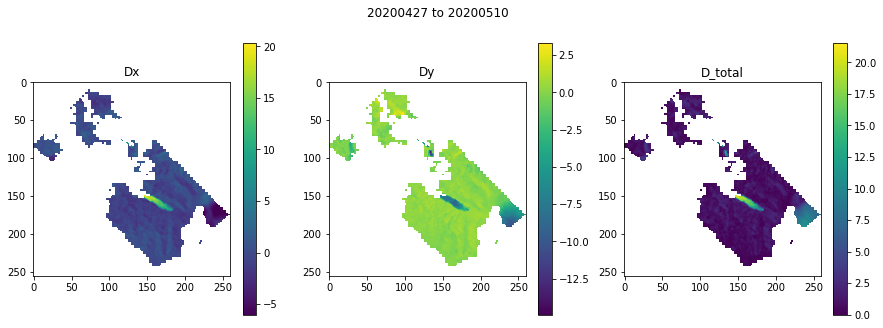

Write Outputs Start!!!
Offset.mat written.
Offset.tif written.
Velocity.tif written.
Write Outputs Done!!!
0.024838924407958984


In [19]:
# AutoRIFT    
if img_type == 'OPT':  
    optflag = 1 # turn on optical flag
    ############ Coregister and read in the two images (from loadProductOptical()) #############
    obj = GeogridOptical()
    x1a, y1a, xsize1, ysize1, x2a, y2a, xsize2, ysize2, trans = obj.coregister(indir_m, indir_s,0)
    
    # read dates from filenames
    if 'LC' in indir_m and 'LC' in indir_s:
        ds1 = indir_m.split('/')[-1].split('_')[3]; ds2 = indir_s.split('/')[-1].split('_')[3]
        sat = 'LS'
    elif 'S2' in indir_m and 'S2' in indir_s:
        ds1 = indir_m.split('/')[-1][9:17]; ds2 = indir_s.split('/')[-1][9:17]
        sat = 'S2'
    elif 'PS' in im1_name and 'PS' in im2_name:
        ds1 = indir_m.split('/')[-1].split('_')[1]
        ds2 = indir_s.split('/')[-1].split('_')[1]
        sat = 'PS'
    else:
        raise Exception('Optical data NOT supported yet!') 
    
    # read in the images
    DS1 = gdal.Open(indir_m); DS2 = gdal.Open(indir_s)
    I1 = DS1.ReadAsArray(xoff=x1a, yoff=y1a, xsize=xsize1, ysize=ysize1)
    I1 = I1.astype(np.float32)
    I2 = DS2.ReadAsArray(xoff=x2a, yoff=y2a, xsize=xsize2, ysize=ysize2)
    I2 = I2.astype(np.float32)
    DS1=None; DS2=None # clear DS1 and DS2
    
    ############## Initialize autoRIFT object (from runAutorift()) ############################
    obj = autoRIFT_ISCE()
    obj.configure()
    obj.MultiThread = mpflag # multiprocessing
    
    obj.I1 = I1; obj.I2 = I2 # assign the images
    obj.xGrid = xGrid; obj.yGrid = yGrid # assign the grid 

    # GENERATE NO DATA MASK
    # where offset searching will be skipped based on 
    # 1) imported nodata mask and/or 2) zero values in the image
    for ii in range(obj.xGrid.shape[0]):
        for jj in range(obj.xGrid.shape[1]):
            if (obj.yGrid[ii,jj] != nodata)&(obj.xGrid[ii,jj] != nodata):
                if (I1[obj.yGrid[ii,jj]-1,obj.xGrid[ii,jj]-1]==0)|(I2[obj.yGrid[ii,jj]-1,obj.xGrid[ii,jj]-1]==0):
                    noDataMask[ii,jj] = True
                    
    # SEARCH RANGE
    if SRx0 is None:
        # default is a zero array
#        ###########     uncomment to customize SearchLimit based on velocity distribution 
        if Dx0 is not None:
            obj.SearchLimitX = np.int32(4+(25-4)/(np.max(np.abs(Dx0[np.logical_not(noDataMask)]))-np.min(np.abs(Dx0[np.logical_not(noDataMask)])))*(np.abs(Dx0)-np.min(np.abs(Dx0[np.logical_not(noDataMask)]))))
        else:
            obj.SearchLimitX = 15
        obj.SearchLimitY = 15
#        ###########
        obj.SearchLimitX = obj.SearchLimitX * np.logical_not(noDataMask)
        obj.SearchLimitY = obj.SearchLimitY * np.logical_not(noDataMask)
    else:
        obj.SearchLimitX = SRx0
        obj.SearchLimitY = SRy0
       ############ add buffer to search range
        obj.SearchLimitX[obj.SearchLimitX!=0] = obj.SearchLimitX[obj.SearchLimitX!=0] + 2
        obj.SearchLimitY[obj.SearchLimitY!=0] = obj.SearchLimitY[obj.SearchLimitY!=0] + 2
    
    # CHIP SIZE
    if CSMINx0 is not None:
        obj.ChipSizeMaxX = CSMAXx0
        obj.ChipSizeMinX = CSMINx0
        
        gridspacingx = CHIPSIZE_M # use the grid spacing from above
        chipsizex0 = MINCHIPSIZE
        pixsizex = trans[1] # grab from coregister function
    
        obj.ChipSize0X = int(np.ceil(chipsizex0/pixsizex/4)*4)
        obj.GridSpacingX = int(obj.ChipSize0X*gridspacingx/chipsizex0)

        RATIO_Y2X = CSMINy0/CSMINx0
        obj.ScaleChipSizeY = np.median(RATIO_Y2X[(CSMINx0!=nodata)&(CSMINy0!=nodata)])
#         obj.ScaleChipSizeY = 1 # USE SCALE OF 1 for square pixels
    else:
        if ((optflag == 1)&(xGrid is not None)):
            obj.ChipSizeMaxX = 32 # pixels
            obj.ChipSizeMinX = 16 # pixels
            obj.ChipSize0X = 16 # pixels
    
    # DOWNSTREAM SEARCH OFFSET
    if Dx0 is not None:
        obj.Dx0 = Dx0
        obj.Dy0 = Dy0
    else:
        obj.Dx0 = obj.Dx0 * np.logical_not(noDataMask)
        obj.Dy0 = obj.Dy0 * np.logical_not(noDataMask)

    # REPLACE NO DATA VALUES WITH 0
    obj.xGrid[noDataMask] = 0
    obj.yGrid[noDataMask] = 0
    obj.Dx0[noDataMask] = 0
    obj.Dy0[noDataMask] = 0
    if SRx0 is not None:
        obj.SearchLimitX[noDataMask] = 0
        obj.SearchLimitY[noDataMask] = 0
    if CSMINx0 is not None:
        obj.ChipSizeMaxX[noDataMask] = 0
        obj.ChipSizeMinX[noDataMask] = 0

    ############## AutoRIFT Pre-processing (from runAutorift()) ############################
    t1 = time.time()
    print("Pre-process Start!!!")
    
    # FILTERING:
    if FILTER == 'WAL': 
        obj.preprocess_filt_wal() # WALLIS FILTER
#         obj.zeroMask = 1 # removes edges
        obj.WallisFilterWidth = WALLISFILTERWIDTH # optional, default supposedly 21
    elif FILTER == 'HPS':
        obj.preprocess_filt_hps() # HIGH PASS FILTER
    elif FILTER == 'SOB':
        obj.preprocess_filt_sob() # SOBEL FILTER
    elif FILTER == 'LAP':
        obj.preprocess_filt_lap()
    elif FILTER == 'DB':
        obj.preprocess_db() # LOGARITHMIC OPERATOR (NO FILTER), FOR TOPOGRAPHY
    else:
        print(FILTER, 'not recognized. Using default high pass filter instead.')
        obj.preprocess_filt_hps() # HIGH PASS FILTER
        
    print("Pre-process Done!!!")
    print(time.time()-t1)
    
    # CONVERT TO UNIFORM DATA TYPE
    t1 = time.time()
#    obj.DataType = 0
    obj.uniform_data_type()
    print("Uniform Data Type Done!!!")
    print(time.time()-t1)
    
    # OTHER :
    obj.sparseSearchSampleRate = 1
#    obj.colfiltChunkSize = 4

    obj.OverSampleRatio = 64
    if CSMINx0 is not None:
        obj.OverSampleRatio = {obj.ChipSize0X:16,obj.ChipSize0X*2:32,obj.ChipSize0X*4:64,obj.ChipSize0X*8:64}
    
    # SEE ORIGINAL CODE TO EXPORT PREPROCESSED IMAGES
    
    ####################### Run AutoRIFT (from runAutorift())  ############################
    t1 = time.time()
    print("AutoRIFT Start!!!")
    obj.runAutorift()
    print("AutoRIFT Done!!!")
    print(time.time()-t1)
    
    kernel = np.ones((3,3),np.uint8)
    noDataMask = cv2.dilate(noDataMask.astype(np.uint8),kernel,iterations = 1)
    noDataMask = noDataMask.astype(np.bool)

    # AT THIS POINT, THESE VARIABLES WILL BE CREATED:
    # obj.Dx, obj.Dy, obj.InterpMask, obj.ChipSizeX, obj.GridSpacingX, 
    # obj.ScaleChipSizeY, obj.SearchLimitX, obj.SearchLimitY, obj.origSize, noDataMask
    
    # PLOT RESULTS
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
    im1 = ax1.imshow(obj.Dx); ax1.set_title('Dx'); fig.colorbar(im1, ax=ax1)
    im2 = ax2.imshow(obj.Dy); ax2.set_title('Dy'); fig.colorbar(im2, ax=ax2)
    im3 = ax3.imshow(np.sqrt((obj.Dx**2) + (obj.Dy**2))); ax3.set_title('D_total'); fig.colorbar(im3,ax=ax3)
    plt.suptitle(ds1+' to '+ds2)
    plt.show()

    ####################### Write outputs (from runAutorift())  ############################
    t1 = time.time()
    print("Write Outputs Start!!!")
    
    # open the window_location.tif file to gdalinfo
    ds = gdal.Open(gp+'window_location.tif')
    tran = ds.GetGeoTransform()
    proj = ds.GetProjection()
    srs = ds.GetSpatialRef()
    
    # initialize arrays
    DX = np.zeros(origSize,dtype=np.float32) * np.nan; DY = np.zeros(origSize,dtype=np.float32) * np.nan
    INTERPMASK = np.zeros(origSize,dtype=np.float32); CHIPSIZEX = np.zeros(origSize,dtype=np.float32)
    SEARCHLIMITX = np.zeros(origSize,dtype=np.float32); SEARCHLIMITY = np.zeros(origSize,dtype=np.float32)
    
    # fill in arays
    Dx = obj.Dx; Dy = obj.Dy; InterpMask = obj.InterpMask; ChipSizeX = obj.ChipSizeX
    SearchLimitX = obj.SearchLimitX; SearchLimitY = obj.SearchLimitY
    DX[0:Dx.shape[0],0:Dx.shape[1]] = Dx;  DY[0:Dy.shape[0],0:Dy.shape[1]] = Dy
    INTERPMASK[0:InterpMask.shape[0],0:InterpMask.shape[1]] = InterpMask
    CHIPSIZEX[0:ChipSizeX.shape[0],0:ChipSizeX.shape[1]] = ChipSizeX
    SEARCHLIMITX[0:SearchLimitX.shape[0],0:SearchLimitX.shape[1]] = SearchLimitX
    SEARCHLIMITY[0:SearchLimitY.shape[0],0:SearchLimitY.shape[1]] = SearchLimitY
    
    # mask out no data
    DX[noDataMask] = np.nan; DY[noDataMask] = np.nan
    INTERPMASK[noDataMask] = 0; CHIPSIZEX[noDataMask] = 0
    SEARCHLIMITX[noDataMask] = 0; SEARCHLIMITY[noDataMask] = 0
    if SSM is not None:
        SSM[noDataMask] = False
    DX[SEARCHLIMITX == 0] = np.nan; DY[SEARCHLIMITX == 0] = np.nan
    INTERPMASK[SEARCHLIMITX == 0] = 0; CHIPSIZEX[SEARCHLIMITX == 0] = 0
    if SSM is not None:
        SSM[SEARCHLIMITX == 0] = False

    # SAVE TO OFFSET.MAT FILE
    sio.savemat('offset_'+ds1+'_'+ds2+'_'+str(CHIPSIZE_M)+'m_'+sat+'.mat', # offset mat filename
                {'Dx':DX,'Dy':DY,'InterpMask':INTERPMASK,'ChipSizeX':CHIPSIZEX})
    print('Offset.mat written.')
    
    # CREATE THE GEOTIFFS
    driver = gdal.GetDriverByName('GTiff')
    
    # OFFSET.TIF
    outRaster = driver.Create("offset_"+ds1+'_'+ds2+'_'+str(CHIPSIZE_M)+'m_'+sat+".tif", # offset filename
                              int(xGrid.shape[1]), int(xGrid.shape[0]), 5, gdal.GDT_Float32)
    outRaster.SetGeoTransform(tran); outRaster.SetProjection(proj) # projections
    outband = outRaster.GetRasterBand(1); outband.WriteArray(DX) # DX
    outband.FlushCache()
    outband = outRaster.GetRasterBand(2); outband.WriteArray(DY) # DY
    outband.FlushCache()
    outband = outRaster.GetRasterBand(3); outband.WriteArray(np.sqrt((DX**2) + (DY**2))) # DY
    outband.FlushCache()
    outband = outRaster.GetRasterBand(4); outband.WriteArray(INTERPMASK) # INTERPMASK
    outband.FlushCache()
    outband = outRaster.GetRasterBand(5); outband.WriteArray(CHIPSIZEX) # CHIPSIZE
    outband.FlushCache()
    del outRaster
    print('Offset.tif written.')
    
    # VELOCITY.TIF
    if offset2vx is not None and offset2vy is not None:
        ds = gdal.Open(offset2vx) #### VX
        band = ds.GetRasterBand(1); offset2vx_1 = band.ReadAsArray()
        band = ds.GetRasterBand(2); offset2vx_2 = band.ReadAsArray()
        if ds.RasterCount > 2:
                band = ds.GetRasterBand(3)
                offset2vr = band.ReadAsArray()
        else:
                offset2vr = None
        band=None; ds=None
        offset2vx_1[offset2vx_1 == nodata] = np.nan
        offset2vx_2[offset2vx_2 == nodata] = np.nan

        ds = gdal.Open(offset2vy) #### VY
        band = ds.GetRasterBand(1); offset2vy_1 = band.ReadAsArray()
        band = ds.GetRasterBand(2); offset2vy_2 = band.ReadAsArray()
        if ds.RasterCount > 2:
                band = ds.GetRasterBand(3)
                offset2va = band.ReadAsArray()
        else:
                offset2va = None
        band=None; ds=None
        offset2vy_1[offset2vy_1 == nodata] = np.nan; offset2vy_2[offset2vy_2 == nodata] = np.nan
        
        if offset2va is not None:
            offset2va[offset2va == nodata] = np.nan

        VX = offset2vx_1 * DX + offset2vx_2 * DY
        VY = offset2vy_1 * DX + offset2vy_2 * DY
        VX = VX.astype(np.float32); VY = VY.astype(np.float32)

        outRaster = driver.Create("velocity_"+ds1+'_'+ds2+'_'+str(CHIPSIZE_M)+'m_'+sat+".tif", # velocity filename
                                  int(xGrid.shape[1]), int(xGrid.shape[0]), 3, gdal.GDT_Float32)
        outRaster.SetGeoTransform(tran); outRaster.SetProjection(proj)
        outband = outRaster.GetRasterBand(1); outband.WriteArray(VX) # VX
        outband.FlushCache()
        outband = outRaster.GetRasterBand(2); outband.WriteArray(VY) # VY
        outband.FlushCache()
        outband = outRaster.GetRasterBand(3); outband.WriteArray(np.sqrt((VX**2) + (VY**2))) # V
        outband.FlushCache()
        del outRaster
        print('Velocity.tif written.')
            
    print("Write Outputs Done!!!")
    print(time.time()-t1)
    
    # Move files produced to the out_path directory
    for file in os.listdir(os.getcwd()):
        if 'offset' in file or ('velocity' in file and '.tif' in file):
            shutil.move(os.getcwd()+'/'+file, out_path+file)
        
elif img_type == 'SAR':
    print('SAR in development.')
    optflag = 0 # turn off opt flag
    
    obj = autoRIFT_ISCE()
    obj.configure()
    obj.MultiThread = mpflag
    
    I1 = np.abs(I1); I2 = np.abs(I2) # SAR amplitude only
    
    #   OverSampleRatio can be assigned as a scalar (such as the above line) or as a Python dictionary below 
    #   for intellgient use (ChipSize-dependent). Here, four chip sizes are used: ChipSize0X*[1,2,4,8] and 
    #   four OverSampleRatio are considered [16,32,64,128]. 
    #   The selection of ratios for the optical data flag is based on Landsat-8 data over an inland region 
    #   (thus stable and not moving much) of Greenland, while that for the radar flag (optflag = 0) 
    #   is based on Sentinel-1 data over the same region of Greenland.
    if CSMINx0 is not None:
        obj.OverSampleRatio = {obj.ChipSize0X:32,obj.ChipSize0X*2:64,obj.ChipSize0X*4:128,obj.ChipSize0X*8:128}  
    

else:
    print("Image type not recognized. Use either 'OPT' or 'SAR'.")

In [183]:
chipsizex0

160

In [145]:
int(np.ceil(chipsizex0/pixsizex/4)*4)

16

In [146]:
int(obj.ChipSize0X*gridspacingx/chipsizex0)

16